# BASICS 03 - HOTS in PyTorch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tonic, torch
from utils import timesurface, get_loader, get_dataset_info, plot_kernels, plot_weight_distribution
import matplotlib.pyplot as plt
from tqdm import tqdm
%cd ../hots
from layer import hotslayer

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.15
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [3]:
torch.cuda.max_memory_reserved(device=None)

0

In [4]:
transform = tonic.transforms.NumpyAsType(int)
dataset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform)
loader = get_loader(dataset, kfold = 1000, shuffle=True)
#get_dataset_info(dataset, properties = ['time', 'mean_isi', 'nb_events']);
print(f'number of samples in the dataset: {len(loader)}')

number of samples in the dataset: 60


In [5]:
def hotsnetwork(loader, ordering, Rz, N_neuronz, tauz, filtering_threshold, sensor_size, clustering = True, network=None, device='cuda', verbose=True):
    n_pola = [N_neuronz[L] for L in range(len(Rz)-1)]
    n_pola.insert(0,2)
    ts_size = [(2*Rz[L]+1)**2*n_pola[L] for L in range(len(Rz))]
    p_index = dataset.ordering.index('p')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if verbose: print(f'device -> {device}')

    torch.set_default_tensor_type("torch.DoubleTensor")

    with torch.no_grad():
        if network is not None:
            network = network
        else:
            network = [hotslayer(ts_size[L], N_neuronz[L], device=device) for L in range(len(Rz))]
            
        for L in range(len(network)):
            network[L].clustering_flag = True if clustering else False
            network[L].to(device)

        for events, target in tqdm(loader):
            for L in range(len(Rz)):
                all_ts, ind_filtered = timesurface(events.squeeze(0), (sensor_size[0], sensor_size[1], n_pola[L]), ordering, tau = tauz[L], surface_dimensions=[2*Rz[L]+1,2*Rz[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                #network[L].to(device)
                n_star = network[L](all_ts)
                if ind_filtered is not None:
                    events = events[:,ind_filtered,:]
                events[0,:,p_index] = n_star.cpu()
                del all_ts
                torch.cuda.empty_cache()
                #network[L].to('cpu')
    return network

In [6]:
Rz = (2, 4, 8)
N_neuronz = (4, 8, 16)
tauz = (5e3, 5e4, 5e5)
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]

network = hotsnetwork(loader, dataset.ordering, Rz, N_neuronz, tauz, filtering_threshold, dataset.sensor_size)

device -> cuda
0
cpu
2097152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [05:09<00:00,  5.15s/it]


In [35]:
for L in range(len(Rz)):
    network[L].to('')
    torch.cuda.empty_cache()
    print(network[L].synapses.weight.device)

cuda:0
cuda:0
cuda:0


In [36]:
del network
torch.cuda.empty_cache()

In [37]:
n_pola = [N_neuronz[L] for L in range(len(Rz)-1)]
n_pola.insert(0,2)
for L in range(len(network)):
    plot_kernels(network[L].to('cpu'), n_pola[L], Rz[L], width = 10)

NameError: name 'network' is not defined

## TODO: 
- add plotlayer from neuronhots
- add plot of the loss 

In [ ]:
def hots_coding(loader, ordering, Rz, N_neuronz, tauz, filtering_threshold, sensor_size, device='cuda', verbose=True):
    n_pola = [N_neuronz[L] for L in range(len(Rz)-1)]
    n_pola.insert(0,2)
    ts_size = [(2*Rz[L]+1)**2*n_pola[L] for L in range(len(Rz))]
    p_index = dataset.ordering.index('p')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if verbose: print(f'device -> {device}')

    torch.set_default_tensor_type("torch.DoubleTensor")

    with torch.no_grad():
        output_pola = []
        network = [hotslayer(ts_size[L], N_neuronz[L], device=device) for L in range(len(Rz))]

        for events, target in tqdm(loader):
            for L in range(len(Rz)):
                all_ts, ind_filtered = timesurface(events.squeeze(0), (sensor_size[0], sensor_size[1], n_pola[L]), ordering, tau = tauz[L], surface_dimensions=[2*Rz[L]+1,2*Rz[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                network[L].to(device)
                n_star = network[L](all_ts)
                if ind_filtered is not None:
                    events = events[:,ind_filtered,:]
                events[0,:,p_index] = n_star.cpu()
                del all_ts
                torch.cuda.empty_cache()
                #network[L].to('cpu')
    return network

In [5]:
R = (2, 4, 8)
n_neurons = (4, 8, 16)
n_pola = 2
ts_size1 = (2*R[0]+1)**2*n_pola
tau = (5e3, 5e4, 5e5)#7e2
ts_size2 = (2*R[1]+1)**2*n_neurons[0]
ts_size3 = (2*R[2]+1)**2*n_neurons[1]
verbose = True

p_index = dataset.ordering.index('p')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if verbose: print(f'device -> {device}')

torch.set_default_tensor_type("torch.DoubleTensor")

with torch.no_grad():
    output_pola = []
    layer1 = hotslayer(ts_size1, n_neurons[0], device=device)
    #layer1.learning_flag = False
    #layer1.to(device)
    layer2 = hotslayer(ts_size2, n_neurons[1], device=device)
    #layer2.learning_flag = False
    #layer2.to(device)
    layer3 = hotslayer(ts_size3, n_neurons[2], device=device)
    #layer3.learning_flag = False
    #layer3.to(device)
    for events, target in tqdm(loader):
        all_ts, ind_filtered = timesurface(events.squeeze(0), dataset.sensor_size, dataset.ordering, tau = tau[0], surface_dimensions=[2*R[0]+1,2*R[0]+1], filtering_threshold = 2*R[0], device=device)
        layer1.to(device)
        n_star = layer1(all_ts.to(device).squeeze(0))
        layer1.to('cpu')
        if ind_filtered is not None:
            events = events[:,ind_filtered,:]
        events[0,:,p_index] = n_star.cpu()
        sensor_size = [dataset.sensor_size[0], dataset.sensor_size[1], n_neurons[0]]
        del all_ts
        torch.cuda.empty_cache()
        all_ts, ind_filtered = timesurface(events.squeeze(0), sensor_size, dataset.ordering, tau = tau[1], surface_dimensions=[2*R[1]+1,2*R[1]+1], filtering_threshold = 2*R[1], device=device)
        layer2.to(device)
        n_star = layer2(all_ts.to(device).squeeze(0))
        layer2.to('cpu')
        sensor_size = [dataset.sensor_size[0], dataset.sensor_size[1], n_neurons[1]]
        if ind_filtered is not None:
            events = events[:,ind_filtered,:]
        events[0,:,p_index] = n_star.cpu()
        del all_ts
        torch.cuda.empty_cache()
        all_ts, ind_filtered = timesurface(events.squeeze(0), sensor_size, dataset.ordering, tau = tau[2], surface_dimensions=[2*R[2]+1,2*R[2]+1], filtering_threshold = 2*R[2], device=device)
        layer3.to(device)
        n_star = layer3(all_ts.to(device).squeeze(0))
        layer3.to('cpu')
        if ind_filtered is not None:
            events = events[:,ind_filtered,:]
        events[0,:,p_index] = n_star.cpu()
        output_pola.append(n_star.cpu())
        del all_ts
        torch.cuda.empty_cache()

device -> cuda


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [17:14<00:00,  5.17s/it]


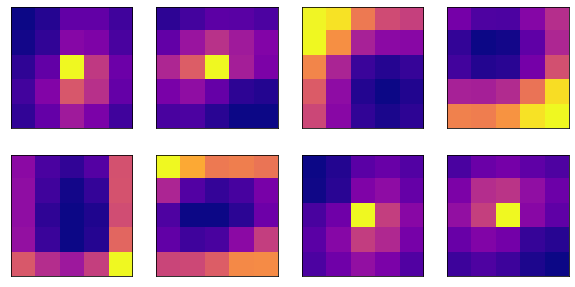

In [6]:
plot_kernels(layer1, n_pola, R[0], width = 10)

In [20]:
print(n_star)

tensor(13, device='cuda:0')


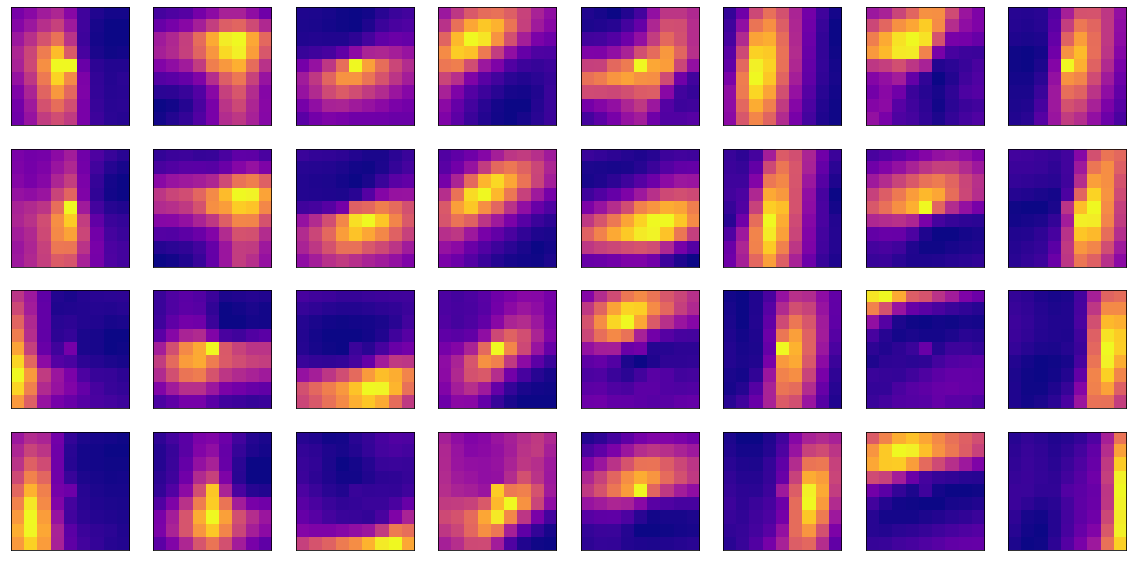

In [7]:
plot_kernels(layer2, n_neurons[0], R[1], width = 20)

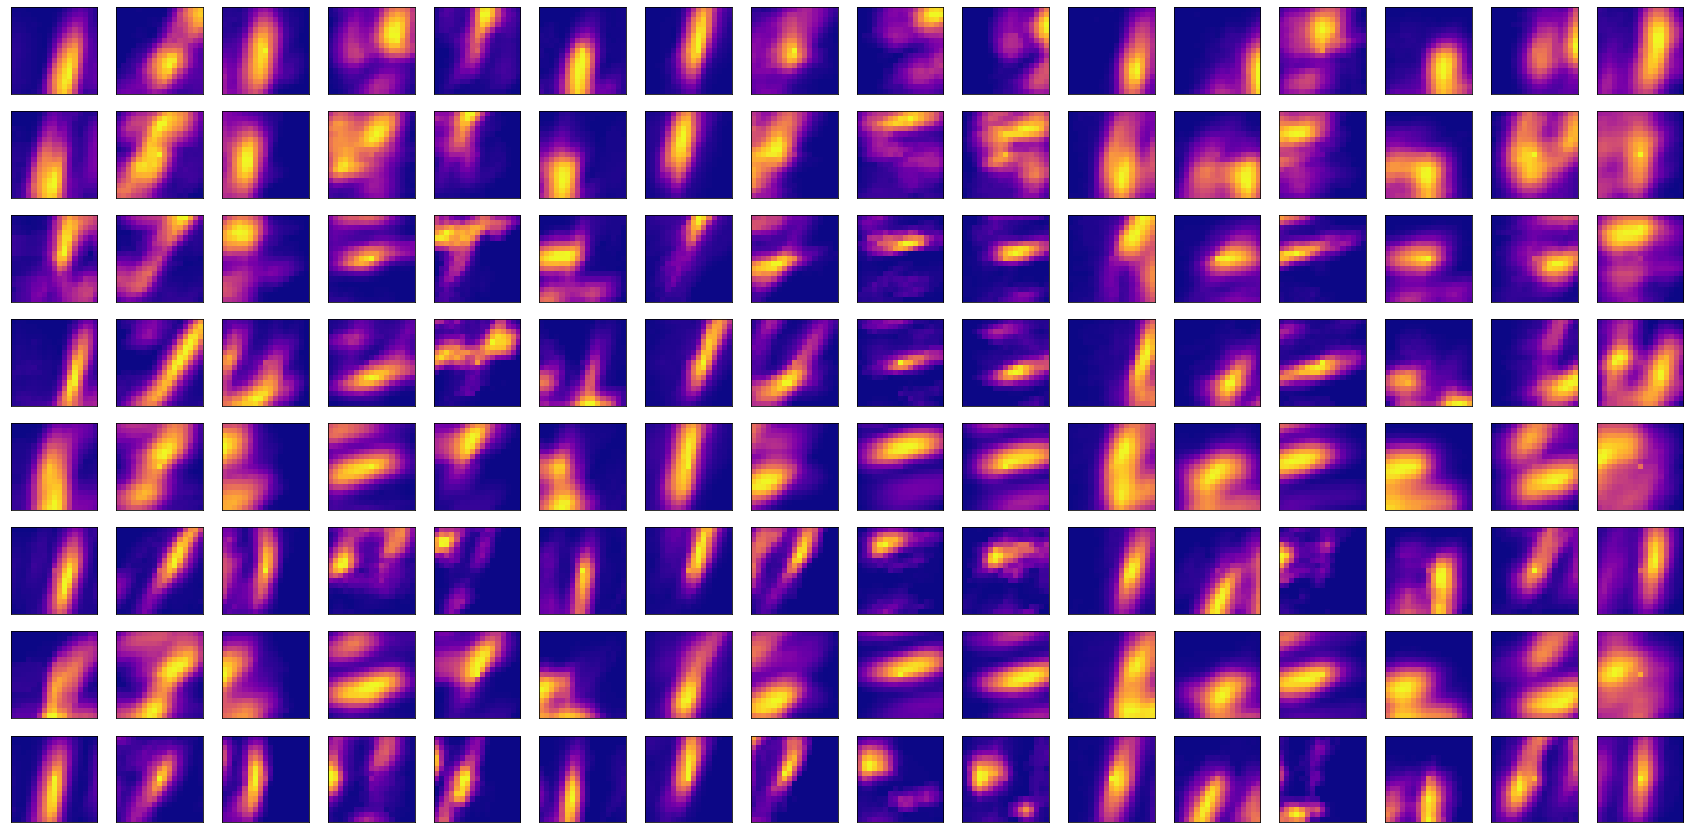

In [8]:
plot_kernels(layer3, n_neurons[1], R[2], width = 30)

## Without homeostasis

In [9]:
with torch.no_grad():
    output_pola = []
    layer1 = hotslayer(ts_size1, n_neurons[0], device=device, homeostasis=False)
    layer2 = hotslayer(ts_size2, n_neurons[1], device=device, homeostasis=False)
    layer3 = hotslayer(ts_size3, n_neurons[2], device=device, homeostasis=False)
    for events, target in tqdm(loader):
        all_ts, ind_filtered = timesurface(events.squeeze(0), dataset.sensor_size, dataset.ordering, tau = tau[0], surface_dimensions=[2*R[0]+1,2*R[0]+1], filtering_threshold = 2*R[0], device=device)
        layer1.to(device)
        n_star = layer1(all_ts.to(device).squeeze(0))
        layer1.to('cpu')
        if ind_filtered is not None:
            events = events[:,ind_filtered,:]
        events[0,:,p_index] = n_star.cpu()
        sensor_size = [dataset.sensor_size[0], dataset.sensor_size[1], n_neurons[0]]
        del all_ts
        torch.cuda.empty_cache()
        all_ts, ind_filtered = timesurface(events.squeeze(0), sensor_size, dataset.ordering, tau = tau[1], surface_dimensions=[2*R[1]+1,2*R[1]+1], filtering_threshold = 2*R[1], device=device)
        layer2.to(device)
        n_star = layer2(all_ts.to(device).squeeze(0))
        layer2.to('cpu')
        sensor_size = [dataset.sensor_size[0], dataset.sensor_size[1], n_neurons[1]]
        if ind_filtered is not None:
            events = events[:,ind_filtered,:]
        events[0,:,p_index] = n_star.cpu()
        del all_ts
        torch.cuda.empty_cache()
        all_ts, ind_filtered = timesurface(events.squeeze(0), sensor_size, dataset.ordering, tau = tau[2], surface_dimensions=[2*R[2]+1,2*R[2]+1], filtering_threshold = 2*R[2], device=device)
        layer3.to(device)
        n_star = layer3(all_ts.to(device).squeeze(0))
        layer3.to('cpu')
        if ind_filtered is not None:
            events = events[:,ind_filtered,:]
        events[0,:,p_index] = n_star.cpu()
        output_pola.append(n_star.cpu())
        del all_ts
        torch.cuda.empty_cache()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [13:15<00:00,  3.98s/it]


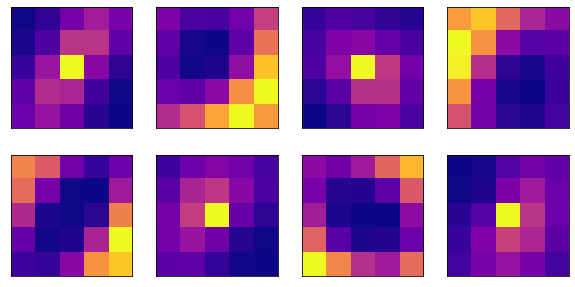

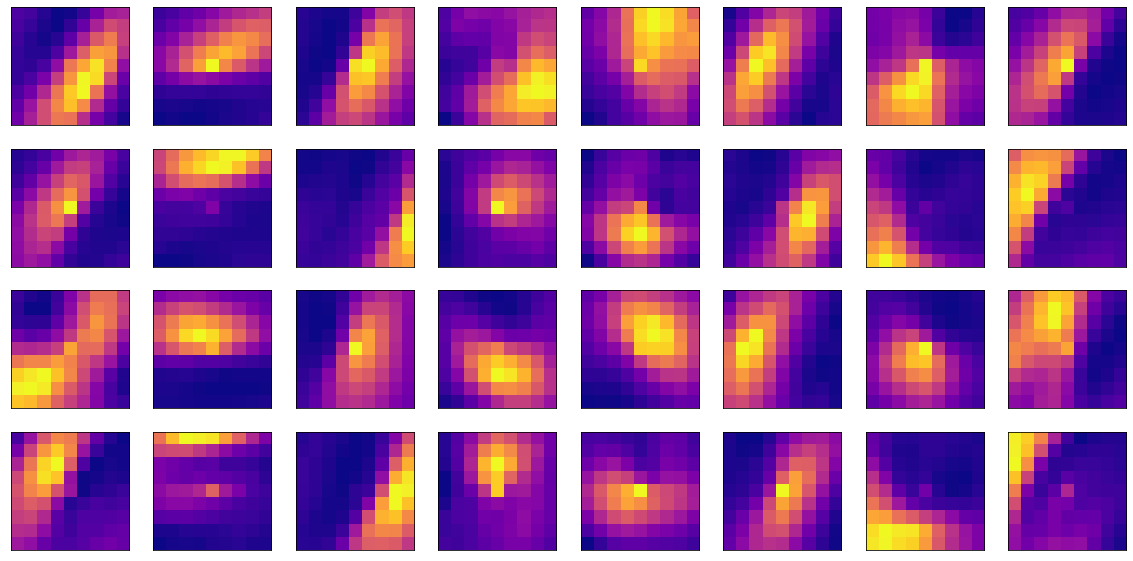

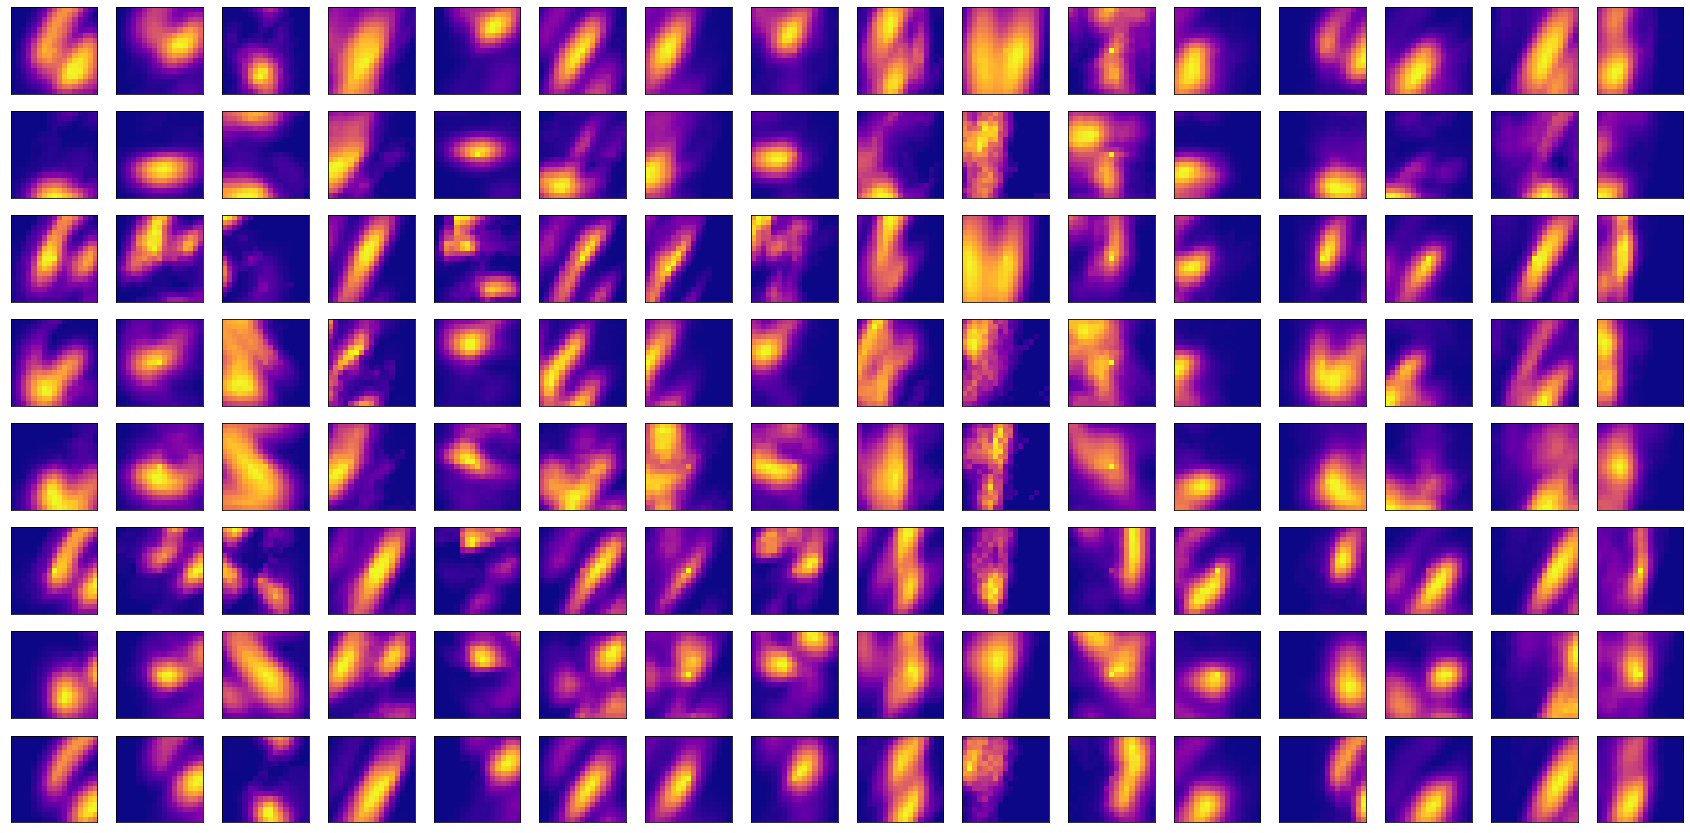

In [11]:
plot_kernels(layer1, n_pola, R[0], width = 10)
plot_kernels(layer2, n_neurons[0], R[1], width = 20)
plot_kernels(layer3, n_neurons[1], R[2], width = 30)

<BarContainer object of 4 artists>

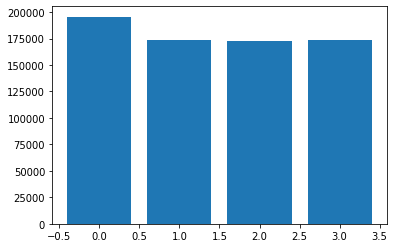

In [21]:
plt.bar(torch.arange(n_neurons[0]),layer1.cumhisto.to('cpu'))

<BarContainer object of 8 artists>

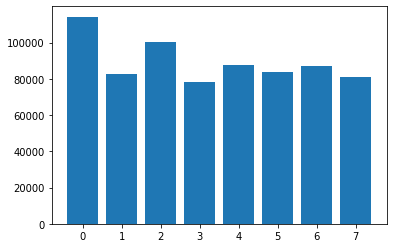

In [19]:
plt.bar(torch.arange(n_neurons[1]),layer2.cumhisto.to('cpu'))

<BarContainer object of 16 artists>

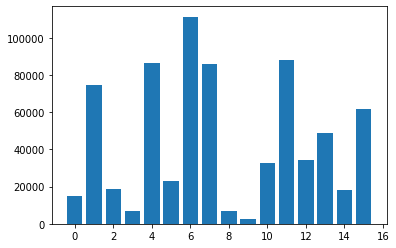

In [20]:
plt.bar(torch.arange(n_neurons[2]),layer3.cumhisto.to('cpu'))

In [27]:
import numpy as np
tau1, tau2, tau3 = 1, 100, 3000
dt = np.random.randint(1)
np.exp(-dt/tau2) == np.exp(-dt/tau1)**(tau1/tau2)

True